#Import Libraries

In [ ]:
!pip install datasets
!pip install transformers

In [ ]:
import os
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import datasets
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

#Dataset

##Download

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
!kaggle datasets download -d spsayakpaul/arxiv-paper-abstracts

 74% 33.0M/44.6M [00:02<00:00, 13.2MB/s]
100% 44.6M/44.6M [00:02<00:00, 15.9MB/s]


In [ ]:
!unzip /content/arxiv-paper-abstracts.zip

Archive:  /content/arxiv-paper-abstracts.zip
  inflating: arxiv_data.csv          
  inflating: arxiv_data_210930-054931.csv  


##Perpare

In [ ]:
df_1 = pd.read_csv('/content/arxiv_data_210930-054931.csv')

In [ ]:
df_1.drop_duplicates('titles',inplace=True)

In [ ]:
def extract_string(str):
    return str[1:-1]

In [ ]:
df_1['terms_'] = df_1['terms'].apply((lambda x: list(map(extract_string,x.strip('][').split(', ')))))

In [ ]:
df_1['num_of_label'] = df_1['terms_'].apply(len)

In [ ]:
y = list(df_1['num_of_label'].value_counts())
x = list(range(1,len(y)+1))

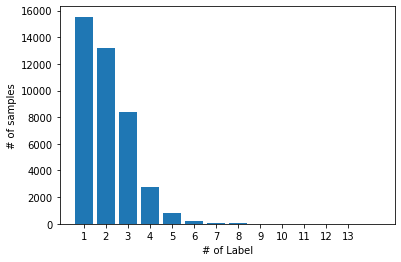

In [ ]:
fig , ax = plt.subplots()
ax.bar(x,y)
ax.set_xlabel('# of Label')
ax.set_ylabel('# of samples')
ax.set_xticks(list(range(1,len(x))))
plt.show()

In [ ]:
labels = df_1['terms_'].to_list()
flatten_list = list(itertools.chain(*labels))
class_count = Counter(flatten_list)
class_count_dic_sorted = dict(sorted(class_count.items(), key=lambda item: item[1],reverse=True))
top_3_class = list(class_count_dic_sorted.keys())[:3]

In [ ]:
top_3_class

['cs.CV', 'cs.LG', 'stat.ML']

In [ ]:
df_1.drop(columns=['index','terms','titles','terms_','num_of_label'],inplace=True)
df_1.reset_index(inplace=True)

In [ ]:
dic_ = {'cs.CV':[],
        'cs.LG':[], 
        'stat.ML':[]}
for _,r in df_1.iterrows():
  list_of_labels = r['terms_']
  list_of_intersection_labels = list(set(list_of_labels) & set(top_3_class))
  list_of_diffrence_labels = list(set(top_3_class) - set(list_of_intersection_labels))
  for item in list_of_intersection_labels:
    dic_[item].append(1)
  for item in list_of_diffrence_labels:
    dic_[item].append(0)

In [ ]:
Counter(dic_['cs.CV'])

Counter({0: 17648, 1: 23457})

In [ ]:
Counter(dic_['cs.LG'])

Counter({0: 17814, 1: 23291})

In [ ]:
Counter(dic_['stat.ML'])

Counter({0: 28004, 1: 13101})

##Convert to HuggingFace Dataset

In [ ]:
df_concat = pd.concat([df_1, pd.DataFrame(dic_)], axis=1)

In [ ]:
df_concat_train = df_concat.iloc[:30000]
df_concat_validation = df_concat.iloc[30000:]

In [ ]:
huggingface_dataset_train = datasets.Dataset.from_pandas(df_concat_train)
huggingface_dataset_validation = datasets.Dataset.from_pandas(df_concat_validation)

In [ ]:
dataset = datasets.DatasetDict()

In [ ]:
dataset['train'] = huggingface_dataset_train
dataset['validation'] = huggingface_dataset_validation

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['abstracts', 'cs.CV', 'cs.LG', 'stat.ML'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['abstracts', 'cs.CV', 'cs.LG', 'stat.ML'],
        num_rows: 11105
    })
})

In [ ]:
example = dataset['train'][0]

In [ ]:
example

{'abstracts': "Graph neural networks (GNNs) have been widely used to learn vector\nrepresentation of graph-structured data and achieved better task performance\nthan conventional methods. The foundation of GNNs is the message passing\nprocedure, which propagates the information in a node to its neighbors. Since\nthis procedure proceeds one step per layer, the range of the information\npropagation among nodes is small in the lower layers, and it expands toward the\nhigher layers. Therefore, a GNN model has to be deep enough to capture global\nstructural information in a graph. On the other hand, it is known that deep GNN\nmodels suffer from performance degradation because they lose nodes' local\ninformation, which would be essential for good model performance, through many\nmessage passing steps. In this study, we propose multi-level attention pooling\n(MLAP) for graph-level classification tasks, which can adapt to both local and\nglobal structural information in a graph. It has an atte

In [ ]:
dataset['train'].features.keys()

dict_keys(['abstracts', 'cs.CV', 'cs.LG', 'stat.ML'])

In [ ]:
labels = [label for label in dataset['train'].features.keys() if label not in ['abstracts']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['cs.CV', 'cs.LG', 'stat.ML']

##Processing

In [ ]:
abstract_len = df_1['abstracts'].apply((lambda x: len(x.split())))

In [ ]:
MAX_LENGTH = max(abstract_len)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["abstracts"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LENGTH)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

In [ ]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['cs.LG']

In [ ]:
encoded_dataset.set_format("torch")

#Training

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

In [ ]:
batch_size = 8
metric_name = "f1"

In [ ]:
args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [ ]:
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput([('loss',
                           tensor(0.6077, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)),
                          ('logits',
                           tensor([[-0.1639,  0.0787, -0.3011]], grad_fn=<AddmmBackward0>))])

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 30000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18750


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.314900,0.305184,0.863326,0.873879,0.707159
2,0.295000,0.317291,0.862862,0.873542,0.701666


***** Running Evaluation *****
  Num examples = 11105
  Batch size = 8
Saving model checkpoint to bert-finetuned-sem_eval-english/checkpoint-3750
Configuration saved in bert-finetuned-sem_eval-english/checkpoint-3750/config.json
Model weights saved in bert-finetuned-sem_eval-english/checkpoint-3750/pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english/checkpoint-3750/tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english/checkpoint-3750/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 11105
  Batch size = 8
Saving model checkpoint to bert-finetuned-sem_eval-english/checkpoint-7500
Configuration saved in bert-finetuned-sem_eval-english/checkpoint-7500/config.json
Model weights saved in bert-finetuned-sem_eval-english/checkpoint-7500/pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english/checkpoint-7500/tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english/

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.314900,0.305184,0.863326,0.873879,0.707159
2,0.295000,0.317291,0.862862,0.873542,0.701666
3,0.264700,0.330243,0.862609,0.873035,0.694102


***** Running Evaluation *****
  Num examples = 11105
  Batch size = 8
Saving model checkpoint to bert-finetuned-sem_eval-english/checkpoint-11250
Configuration saved in bert-finetuned-sem_eval-english/checkpoint-11250/config.json
Model weights saved in bert-finetuned-sem_eval-english/checkpoint-11250/pytorch_model.bin
tokenizer config file saved in bert-finetuned-sem_eval-english/checkpoint-11250/tokenizer_config.json
Special tokens file saved in bert-finetuned-sem_eval-english/checkpoint-11250/special_tokens_map.json


In [ ]:
text = """
Graph neural networks (GNNs) have been widely used to learn vector\nrepresentation of graph-structured data and achieved better task performance\nthan conventional methods. The foundation of GNNs is the message passing\nprocedure, which propagates the information in a node to its neighbors. Since\nthis procedure proceeds one step per layer, the range of the information\npropagation among nodes is small in the lower layers, and it expands toward the\nhigher layers. Therefore, a GNN model has to be deep enough to capture global\nstructural information in a graph. On the other hand, it is known that deep GNN\nmodels suffer from performance degradation because they lose nodes' local\ninformation, which would be essential for good model performance, through many\nmessage passing steps. In this study, we propose multi-level attention pooling\n(MLAP) for graph-level classification tasks, which can adapt to both local and\nglobal structural information in a graph. It has an attention pooling layer for\neach message passing step and computes the final graph representation by\nunifying the layer-wise graph representations. The MLAP architecture allows\nmodels to utilize the structural information of graphs with multiple levels of\nlocalities because it preserves layer-wise information before losing them due\nto oversmoothing. Results of our experiments show that the MLAP architecture\nimproves the graph classification performance compared to the baseline\narchitectures. In addition, analyses on the layer-wise graph representations\nsuggest that aggregating information from multiple levels of localities indeed\nhas the potential to improve the discriminability of learned graph\nrepresentations.
"""

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [ ]:
logits = outputs.logits

In [ ]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)